In [ ]:
!pip install category_encoders

## Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import warnings

import sklearn as sk
import sklearn.metrics as metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import category_encoders as ce

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as smd

import plotly as ply
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',15)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

### Knowing the predictors

|Index|Variable|Description|
|---|---|---|
| 1. | mpg thresh (Target Variable) | mpg values below (0) or above (1) median value |
| 2. | mpg | miles per gallon og fuel |
|3.| cylinders | number of combustion cylinders in engine |
|4.| displacement |  |
|5.| horsepower | horsepower of the engine |
|6.| weight | weight of the vehicle in kg |
|7.| acceleration | maximum acceleration |
|8.| origin | |
|9.| year | Year the vehicle manufacture started |
|10.| name | Name of the model of vehicle |
|11.| cmp name (derived) | vehicle maker name |

In [ ]:
PATH = '/content/drive/MyDrive/data'
DSET_NAME = '/Auto.csv'

data = pd.read_csv(PATH+DSET_NAME,na_values='?')
print(f'The size of the dataset is : {data.shape}\n\n')
data.head()

The size of the dataset is : (397, 9)




,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


We see that there are a good number of errors in data collection, as seen from spelling errors in car name etc. Also, there are 6 missing values in the horsepower so we drop these rows.

In [ ]:
median = np.median(data['mpg'])
data['mpg thresh'] = data['mpg']
data['mpg thresh'] = np.where(data['mpg']>median, 1, 0)

data['cmp name'] = data['name']

for inx, r in enumerate(data['name']):
    cmp_name = r.split(' ')[0]

    #correcting entries
    cmp_name = 'mercedes' if cmp_name == 'mercedes-benz' else cmp_name
    cmp_name = 'volkswagen' if cmp_name in ['vw', 'vokswagen'] else cmp_name
    cmp_name = 'mazda' if cmp_name == 'maxda' else cmp_name
    cmp_name = 'toyota' if cmp_name == 'toyouta' else cmp_name
    cmp_name = 'chevrolet' if cmp_name in ['chevy', 'chevroelt'] else cmp_name
    
    data.loc[inx, 'cmp name'] = cmp_name

print(f'The median value of mpg is : {median}\n\n')
data.head()

The median value of mpg is : 23.0




,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg thresh,cmp name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,chevrolet
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,buick
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,plymouth
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,amc
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,ford


Cleaning and removing duplicates. Transforming categorical variables with binary encoding.

In [ ]:
encoder = ce.BinaryEncoder(cols=['cmp name'])
code = encoder.fit_transform(data['cmp name'])
data = pd.concat([data, code], axis=1)

dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
data=data.dropna()
print(f'The size of the dataset post removing null values and duplicates : {data.shape}\n\n')

data.head()

Number of duplicate rows = 0
The size of the dataset post removing null values and duplicates : (392, 17)




,mpg,cylinders,displacement,horsepower,weight,acceleration,year,...,cmp name,cmp name_0,cmp name_1,cmp name_2,cmp name_3,cmp name_4,cmp name_5
0,18.0,8,307.0,130.0,3504,12.0,70,...,chevrolet,0,0,0,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,...,buick,0,0,0,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,...,plymouth,0,0,0,0,1,1
3,16.0,8,304.0,150.0,3433,12.0,70,...,amc,0,0,0,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,...,ford,0,0,0,1,0,1


### Understanding the data

Year is an important variable since we may observe a temporal correlation in the data. The first important observation indicates that with time the cars were made more fuel efficient thus, giving higher mileage that expected as indicated below.

In [ ]:
distributions = data.groupby(['year','mpg thresh'])['mpg'].count()
x = [i for i in range(70,83)]
below_median = distributions[ [(i,0) for i in range(72,83)] ].values
above_median = distributions[ [(i,1) for i in range(72,83)] ].values

fig = go.Figure()
fig.add_bar(x=x, y=below_median, name='below median MPG')
fig.add_bar(x=x, y=above_median, name='above median MPG')

Another important observation that we need to observe is the trend in mean horsepower, displacement and weight over years. The above predictors seem to have a high correlation and have decreased over years. 

While the above predictors decreased we find that the acceleration has increased over the years.

In [ ]:
tdf = data[['year','displacement', 'horsepower', 'weight', 'acceleration']].groupby('year').median()
x = tdf.index.values

fig = go.Figure()
for c in tdf.columns:
    y = tdf[c].values
    scaler = preprocessing.StandardScaler().fit(y.reshape(-1,1))
    y = scaler.transform(y.reshape(-1,1))
    fig.add_scatter(x=x, y=y.reshape(-1), name=c)

ply.offline.iplot(fig)

As seen in the previous trend we do find that the predictors cylinders, weight, horsepower and displacement are highly correlated indicating that the performance of the discriminative model may remain same whether or not more than one from the correlated set are used for prediction.

In [ ]:
view = data[[ 'year', 'origin', 'cylinders', 'horsepower', 'weight', 'displacement', 'acceleration']]
C = view.corr().values

x_label = ['year', 'origin', 'cylinders', 'horsepower', 'weight', 'displacement', 'acceleration']
y_label = ['year', 'origin', 'cylinders', 'horsepower', 'weight', 'displacement', 'acceleration'] 
z_text = [[str(np.around(y_label,decimals=2)) for y_label in x_label] for x_label in C]

fig = ff.create_annotated_heatmap(C, x=x_label, y=y_label, annotation_text=z_text, colorscale='Viridis')

fig.add_annotation(dict(font=dict(color="black",size=14),  
                        x=0.5, y=-0.15, showarrow=False, text="Predicted value",
                        xref="paper", yref="paper"))


fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35, y=0.5, showarrow=False, text="Real value", textangle=-90,
                        xref="paper", yref="paper"))

fig.update_layout( title_text='<i><b>Correlation matrix</b></i>', autosize=False, 
                   width=500, height=500, margin=dict( l=50, r=50, b=100, t=120, pad=4), 
                   paper_bgcolor="LightSteelBlue")
fig['data'][0]['showscale'] = True

fig.show()

Another important observation that is not temporal is that observed from the dervied attribute __cmp name__. It is easily seen that some vehicle makers prefer more fuel efficient designs than the others. 

While the above might be true we cannot negate the fact that there might be certain makers whose production stopped in the early years while some others started production only in the late years.

In [ ]:
distributions = data.groupby(['cmp name', 'mpg thresh'])['mpg'].count()
k = distributions.keys().values

fig = go.Figure()
fig.add_bar(x=[ i for i,v in k if v==0 ], y=[ distributions[(i,v)] for i,v in k if v==0 ], name='below median mpg')
fig.add_bar(x=[ i for i,v in k if v==1 ], y=[ distributions[(i,v)] for i,v in k if v==1 ], name='above median mpg')

## Model Construction

### Model with no Categorical variables

In the model construction we create train-test random split of 70:30, fit a logistic regression model. This is repeated 100 times to see the variability in model performance both and the deviation of model performance during training to testing.

We first start out by avoiding categorical attribute __cmp name__ and analyse to find that having more than one of the correlated attributes does not increases the model performance significantly and we also see that adding those variables only decreases the stability both in training and testing as the standard deviation increases. Same is with the __origin__ variable.

We also, find that the model performance is comparable in both training and testing despite higher deviation in testing.

In [ ]:
X = data[['displacement', 'acceleration', 'year']]
y = data['mpg thresh']
train_acc, test_acc = [], []
 
for i in range(100):

    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3)
    model = linear_model.LogisticRegression(max_iter=1000).fit(trainX, trainy)
    
    y_pred = np.where(model.predict_proba(trainX)[:,1] >= .5, 1, 0)
    training_acc = np.sum(trainy==y_pred) / len(trainX)
    train_acc.append(training_acc)

    y_pred = np.where(model.predict_proba(testX)[:,1] >= .5, 1, 0)
    testing_acc = np.sum(testy==y_pred) / len(testX)
    test_acc.append(testing_acc)

performance = np.array([[np.max(train_acc),np.max(test_acc)],
                        [np.mean(train_acc),np.mean(test_acc)],
                        [np.std(train_acc),np.std(test_acc)]])

performance = pd.DataFrame(performance*100, index=['max', 'mean', 'std'], columns=['Train', 'Test'])
performance

,Train,Test
max,93.065693,95.762712
mean,89.934307,89.355932
std,1.147379,2.576940


In [ ]:
C = metrics.confusion_matrix(testy,y_pred)

x_label = ['below median', 'above median']
y_label =  ['below median', 'above median']
z_text = [[str(y_label) for y_label in x_label] for x_label in C]

fig = ff.create_annotated_heatmap(C, x=x_label, y=y_label, annotation_text=z_text, colorscale='Viridis')

fig.add_annotation(dict(font=dict(color="black",size=14),  
                        x=0.5, y=-0.15, showarrow=False, text="Predicted value",
                        xref="paper", yref="paper"))


fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35, y=0.5, showarrow=False, text="Real value", textangle=-90,
                        xref="paper", yref="paper"))

fig.update_layout( title_text='<i><b>Confusion matrix</b></i>', autosize=False, 
                   width=500, height=500, margin=dict( l=50, r=50, b=100, t=100, pad=4), 
                   paper_bgcolor="LightSteelBlue")
fig['data'][0]['showscale'] = True

fig.show()


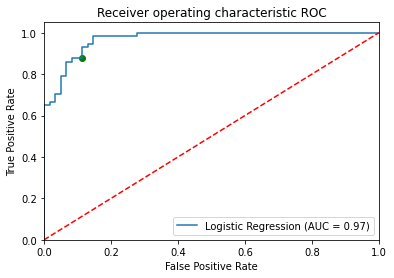

In [ ]:
roc_auc = metrics.roc_auc_score(testy, model.predict_proba(testX)[:, 1])
fpr, tpr, thresholds = metrics.roc_curve(testy, model.predict_proba(testX)[:, 1])

operating_point_index = np.where(np.isclose(np.around(thresholds, decimals=2), 0.50,atol=0.04) == True)[0][0]

plt.figure();
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc);
plt.plot([0, 1], [0, 1],'r--');
plt.scatter(fpr[operating_point_index], tpr[operating_point_index], c="green");
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Receiver operating characteristic ROC');
plt.legend(loc="lower right");

In [ ]:
X = data[['year', 'displacement', 'acceleration']]
y = data['mpg thresh']

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3)
model = smd.Logit(endog=trainy, exog=trainX)
results = model.fit(method='lbfgs')
print(results.summary())

predicted_probs = model.predict(results.params, testX)
predicted_responses = predicted_probs > 0.5
training_acc = np.sum(testy==predicted_responses) / len(testX)
print(f"\n\nTest accuracy:\t{training_acc*100:.2f}%\n\n")

                           Logit Regression Results                           
Dep. Variable:             mpg thresh   No. Observations:                  274
Model:                          Logit   Df Residuals:                      271
Method:                           MLE   Df Model:                            2
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:                  0.5939
Time:                        05:59:17   Log-Likelihood:                -76.882
converged:                       True   LL-Null:                       -189.33
Covariance Type:            nonrobust   LLR p-value:                 1.460e-49
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1584      0.243      4.770      0.000       0.682       1.634
x2            -2.9037      0.347     -8.358      0.000      -3.585      -2.223
x3            -0.1573      0.238     -0.662      0.5

### Model with Categorical variables

We also add the categorical variables to the previous predictors and look at the model performance.

We find that while the training stability increased by a fraction, testing stability has decreased to the same extent. The mean performance of the model remained same in both train and test scenarios, but what did change was the optimal performance that can be achieved. We find that the optimal performance has increased in both test and train cases by close to __1%__. 

In [ ]:
X = data[['displacement', 'acceleration', 'year', 'cmp name_0', 'cmp name_1', 'cmp name_2', 'cmp name_3', 'cmp name_4', 'cmp name_5']]
y = data['mpg thresh']
train_acc, test_acc = [], []
 
for i in range(100):

    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3)
    model = linear_model.LogisticRegression(max_iter=1000).fit(trainX, trainy)
    
    y_pred = np.where(model.predict_proba(trainX)[:,1] >= .5, 1, 0)
    training_acc = np.sum(trainy==y_pred) / len(trainX)
    train_acc.append(training_acc)

    y_pred = np.where(model.predict_proba(testX)[:,1] >= .5, 1, 0)
    testing_acc = np.sum(testy==y_pred) / len(testX)
    test_acc.append(testing_acc)

performance = np.array([[np.max(train_acc),np.max(test_acc)],
                        [np.mean(train_acc),np.mean(test_acc)],
                        [np.std(train_acc),np.std(test_acc)]])

performance = pd.DataFrame(performance*100, index=['max', 'mean', 'std'], columns=['Train', 'Test'])
performance

,Train,Test
max,94.160584,96.610169
mean,91.208029,89.974576
std,1.024625,2.727853


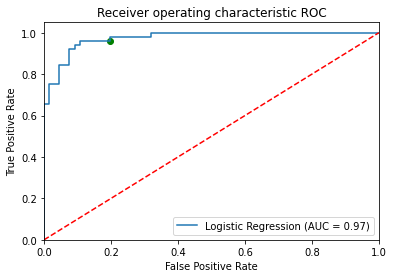

In [ ]:
roc_auc = metrics.roc_auc_score(testy, model.predict_proba(testX)[:, 1])
fpr, tpr, thresholds = metrics.roc_curve(testy, model.predict_proba(testX)[:, 1])

operating_point_index = np.where(np.isclose(np.around(thresholds, decimals=2), 0.50,atol=0.04) == True)[0][0]

plt.figure();
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc);
plt.plot([0, 1], [0, 1],'r--');
plt.scatter(fpr[operating_point_index], tpr[operating_point_index], c="green");
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Receiver operating characteristic ROC');
plt.legend(loc="lower right");

In [ ]:
Xcnt = data[['year', 'displacement', 'acceleration']]
Xcat = data[['cmp name_0', 'cmp name_1', 'cmp name_2', 'cmp name_3', 'cmp name_4', 'cmp name_5']].values
y = data['mpg thresh']

scaler = preprocessing.StandardScaler().fit(Xcnt)
Xcnt = scaler.transform(Xcnt)
X = np.concatenate([Xcnt, Xcat], axis=1)
X = sm.add_constant(X)

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3)
model = smd.Logit(endog=trainy, exog=trainX)
results = model.fit(method='lbfgs')
print(results.summary())

predicted_probs = model.predict(results.params, testX)
predicted_responses = predicted_probs > 0.5
training_acc = np.sum(testy==predicted_responses) / len(testX)
print(f"\n\nTest accuracy:\t{training_acc*100:.2f}%\n\n")

                           Logit Regression Results                           
Dep. Variable:             mpg thresh   No. Observations:                  274
Model:                          Logit   Df Residuals:                      265
Method:                           MLE   Df Model:                            8
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:                  0.7019
Time:                        05:59:23   Log-Likelihood:                -56.407
converged:                       True   LL-Null:                       -189.19
Covariance Type:            nonrobust   LLR p-value:                 8.582e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9145      0.768     -2.494      0.013      -3.419      -0.410
x1             1.6729      0.310      5.402      0.000       1.066       2.280
x2            -4.2248      0.682     -6.194      0.0